# Project 2, all the code and computations

## Imports

We just gather all the imports we need in one code block

In [3]:
import numpy as np
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn import datasets, linear_model
from sklearn.metrics import r2_score, mean_squared_error, accuracy_score, log_loss
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.linear_model import SGDRegressor, SGDClassifier


#np.random.seed(12) # for replication purposes

## Implmentation of Neural Net

In [2]:
def sigmoid(x) : 
    return 1/(1+np.exp(-x))

def dsigmoid(x) :
    return sigmoid(x)*(1-sigmoid(x))

def relu(x) :
    return np.maximum(x,0)

def drelu(x) :
    #return (x > 0)*1
    return np.heaviside(x,0.5)
    
class NN_layer : 
    
    def __init__(self, input_size, output_size, activation_function) : 
        self.activation = activation_function
        self.weights = np.random.uniform(-0.7, 0.7, (input_size, output_size)) 
        self.bias = 0.01*np.random.rand(1, output_size)
    
    # inputs should be a row vector
    # or a matrix with each row having the right dimension 
    def activate(self, inputs) :
        z = (inputs @ self.weights) + self.bias
        a = self.activation(z)
        return a, z

class my_NN :
    
    activation_functions = {
        'sigmoid' : (sigmoid, dsigmoid),
        'linear' : (lambda x : x, lambda x : 1),
        'relu' : (relu, drelu)
    }
    
    # my cost functions really only work when there is a single output
    # so both pred and true below are column vectors 
    # and the output should be a column vector as well
    # For the cross entropy we need to test if pred is zero or 1, since if it is the formula divides by zero'
    # so in that case we simply return 0 (i.e no futher changes needed)
    cost_functions_diff = {
        'square error' : ( lambda pred, target : (pred-target)),
        'cross entropy' : ( lambda pred, target : (pred - target)/(pred*(1-pred)) )
    }
    #'cross entropy' : ( lambda pred, target : (pred - target)/(pred*(1-pred)) if ((not pred.any()) and (not (1-pred).any())) else 0 )
        
    # While we don't actually need the cost_functions themselves to do training, 
    # we still include them
    cost_functions = {
        'square error' : mean_squared_error,
        'cross entropy' : log_loss
    }
    
        
    def __init__(self, layer_sizes, hidden_activation, out_activation) :
        self.hact, self.dhact = self.activation_functions[hidden_activation]
        self.outact, self.doutact = self.activation_functions[out_activation]
        self.number_of_layers = len(layer_sizes)-1
        # add the hidden layers
        self.layers = [NN_layer(layer_sizes[k], layer_sizes[k+1], self.hact) for k in range(0, self.number_of_layers-1)]
        # add the final layer
        self.layers.append(NN_layer(layer_sizes[self.number_of_layers-1], layer_sizes[self.number_of_layers], self.outact))
    
    def feed_forward(self, inputs) :
        acts = [inputs]
        zs = [np.zeros(inputs.shape)] # just put something in the zeros entry of zs, for indexing purposes
        for l in range(0, self.number_of_layers) :
            a,z = self.layers[l].activate(acts[l])
            acts.append(a)
            zs.append(z)
               
        return acts, zs 

    def predict(self, inputs) :
        acts, zs = self.feed_forward(inputs)
        return acts[-1]

    
    def one_step_back_propagate(self, batch, learning_rate, dsummand) :
        batch_size = batch.shape[0] # number of rows in batch
        deltas = [] # list of deltas, build starting from the back
        
        # first feed forward to compute as and zs
        acts, zs = self.feed_forward(batch)

        # Compute deltas, according to formulas from Nielsen's boook
        # http://neuralnetworksanddeeplearning.com/chap2.html
        # Since each delta only depends on the previously computed delta, 
        # we use pythons -1 indexing
        
        # First we define the final delta 
        deltas.append(dsummand(acts[-1])*self.doutact(zs[self.number_of_layers]))
        deltas[-1].reshape(1,-1)
        # then each is defines using the previously computed 
        for layer, z in zip(self.layers[-1::-1], zs[-2:0:-1]) :
            deltas.append((deltas[-1] @ layer.weights.T)*self.dhact(z))
                        
        # Now update the weights and biases
        # We go through the layers and activations from behind, 
        # we do not consider the final activation, as that does not appear in the formulas 
        # We use of np.mean for the bias update but not for the weights, 
        # due to the way matrix multiplication works, (1/batch_size) * (a.T @ delta)
        # is the average row_of_a.T @ row_of_delta (as they run over all row).
        # For the biases we need forcefully take the avarage
        for layer, a, delta in zip(self.layers[::-1], acts[-2::-1], deltas):
            layer.weights = layer.weights - (learning_rate/batch_size) * (a.T @ delta)
            layer.bias = layer.bias - learning_rate * np.mean(delta, axis=0)
            
            
    def train(self, X, Y, cost_function = 'square error', learning_rate = 0.01, epochs = 100, batch_size = 1, verbose = False) :
        N = Y.shape[0] # number of rows in Y, i.e. number of data points
        m = int(N/batch_size) # number of batches
        dsummand = self.cost_functions_diff[cost_function]
        cost = self.cost_functions[cost_function]
        
        # For verbose printing 
        tenpct = epochs // 10
        count = 0
        
        for epo in range(epochs) : 
            if verbose:
                count += 1
                if count == tenpct :
                    print("Working on epoch %d" % epo)
                    print("Before this epoch the loss is %f" % cost(Y, self.predict(X)))
                    count = 0
            #print("The MSE before this epoch is %f" % mean_squared_error(self.predict(X), Y))
            batches = np.random.permutation(N).reshape((-1, m))
            for b in batches :
                X_batch = X[b]
                Y_batch = Y[b].reshape(-1,1) # make Y_batch a column vector
                dout = (lambda a : dsummand(a,Y_batch))
                self.one_step_back_propagate(X_batch, learning_rate, dout)

## Comparing our backpropagation algorithm to sci-kit learn

Following the ideas of the note in piazza (https://piazza.com/class/ji78s1cduul39a?cid=107), we will compare our back propagation to that from sci-kit learn.
We set up a MLPRegressor from scikit learn, make it do one back propergation step, and then compare the weights after we have trained our network. 

In [3]:
import warnings
from sklearn.neural_network import MLPRegressor

X = np.array([[0.0], [1.0]])
y = np.array([0, 2])
mlp = MLPRegressor( solver              = 'sgd',      # Stochastic gradient descent.
                    activation          = 'logistic', # Skl name for sigmoid.
                    alpha               = 0.0,        # No regularization for simplicity.
                    momentum            = 0.0,        # Similarly no momentum to the sgd
                    max_iter            = 1,          # Only do one step per fit call
                    hidden_layer_sizes  = (3, 4))     # Full network is of size (1,3,4,1),

# Force sklearn to set up all the necessary matrices by fitting a data set. 
# We dont care if it converges or not, so lets ignore raised warnings.
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    mlp.fit(X,y)

# We now make my network, and give it the same weights and biases
nn = my_NN([1,3,4,1], 'sigmoid', 'linear')

# we do some random test

for _ in range(0,1000) :
    
    # make random inputs and output to test backpropagation
    X = np.random.rand(1,1)
    target = np.random.rand(1,1)
    
    # We copy the weights and biases from the scikit-learn network to our own.
    # we keep the old weights for record keeping, so we can compute weight changes
    old_weights = []
    old_biases = []
    for i, w in enumerate(mlp.coefs_) :
        nn.layers[i].weights = np.copy(w)
        old_weights.append(np.copy(w))
    for i, b in enumerate(mlp.intercepts_) :
        nn.layers[i].bias = np.copy(b)
        old_biases.append(np.copy(b))

    ########
    # We take a backpropagation step in my network, by simply training with a single epoch
    # To make it easy to compute the gradients, we simply set the learning_rate and bach_size to 1
    my_activations, my_zs = nn.feed_forward(X)
    nn.train(X, target,  learning_rate = 1, epochs = 1, batch_size = 1)
    new_weights = [nn.layers[i].weights for i in range(0,3) ]
    new_biases = [nn.layers[i].bias for i in range(0,3)]
    # Now we can recover the gradients of the weights by looking at the weight differences 
    my_coef_grads = [(ow - nw) for (ow,nw) in zip(old_weights, new_weights)]
    my_bias_grads = [(ob - nb) for (ob, nb) in zip(old_biases, new_biases) ]

    # All this is setup to call the _forward_pass and _backprop methods    
    # ==========================================================================
    n_samples, n_features   = X.shape
    batch_size              = n_samples
    hidden_layer_sizes      = mlp.hidden_layer_sizes
    if not hasattr(hidden_layer_sizes, "__iter__"):
        hidden_layer_sizes = [hidden_layer_sizes]
    hidden_layer_sizes = list(hidden_layer_sizes)
    layer_units = ([n_features] + hidden_layer_sizes + [mlp.n_outputs_])
    activations = [X]
    activations.extend(np.empty((batch_size, n_fan_out)) 
                       for n_fan_out in layer_units[1:])
    deltas      = [np.empty_like(a_layer) for a_layer in activations]
    coef_grads  = [np.empty((n_fan_in_, n_fan_out_)) 
                   for n_fan_in_, n_fan_out_ in zip(layer_units[:-1],
                                                    layer_units[1:])]
    intercept_grads = [np.empty(n_fan_out_) for n_fan_out_ in layer_units[1:]]
    # ==========================================================================

    # This produces activations and gradients from sci-kit learn
    activations                       = mlp._forward_pass(activations) 
    loss, coef_grads, intercept_grads = mlp._backprop(X, target, activations, deltas, coef_grads, intercept_grads)

    # we assert that the activations are the sam
    for (my_acts, mlp_acts) in zip(my_activations, activations) :
        assert np.allclose(my_acts, mlp_acts)

    # we assert that the weight gradients are the same 
    for (my_grad, mlp_grad) in zip(my_coef_grads, coef_grads) : 
        assert np.allclose(my_grad, mlp_grad)

    # we assert that the bias gradients are the same
    for (my_grad, mlp_grad) in zip(my_bias_grads, intercept_grads) : 
        assert np.allclose(my_grad, mlp_grad)

### A simple test of the mean square version of the network

We try to predict a 3rd degree polynomial

Network build and trained


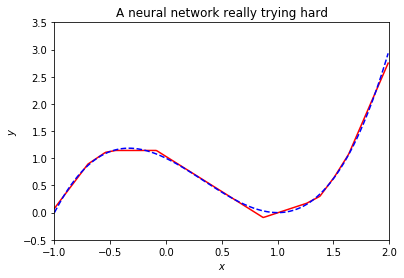

The MSE is 0.001490


In [4]:
#### setup som basic data
#### first the function we are trying to approximate
def p3(x) :
    return (x+1.0)*(x-1.0)*(x-1.0)

#### xs will be a list of random numbers between -1 and 2
xs = 3*np.random.rand(1000,1) - 1 
#### ys are the p3 values of the xs
ys = p3(xs)
# Split our data into training and testing. 
# 20% (0.2) saved to test aginst
x_train, x_test, y_train, y_test = train_test_split(xs, ys, test_size = 0.2)

net = my_NN([1,3,5,7,1], 'relu', 'linear')
#net = my_NN([1,2,1], 'relu', 'linear')
net.train(x_train, y_train, cost_function = 'square error', learning_rate = 0.01, epochs = 300, batch_size = 80)
print("Network build and trained")

# generate a bunch of x's for plotting
xstep = 0.01
xpoints = np.arange(-1.0, 2.0, xstep)

# Compute the predicted y values for all the plotting x's
ypredict = net.predict(xpoints.reshape(-1,1))
#print(ypredict.shape)
#print(ypredict)
# Do the plotting
# first draw a line between the plotting x's and their predicted y's 
plt.plot(xpoints, ypredict, "r-")
# Then plot the points we predicted from
plt.plot(xpoints, p3(xpoints) ,'b--')
# Setup axis and labels
plt.axis([-1.0, 2.0, -0.5, 3.5])
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title(r'A neural network really trying hard')
plt.show()
print("The MSE is %f" % mean_squared_error(net.predict(x_test), y_test))



### Testing the corss entropy version of the network

We are using the moons data set from sci-kit learn

How the logistic regression from sci-kit learn behaves


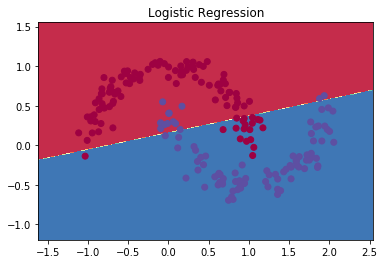

Accuracy: 0.845000

Now building neural network to try to solve the problem
Network build and trained


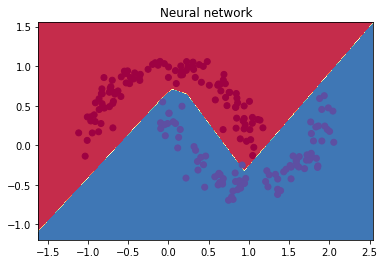

Accuracy: 0.995000


In [5]:
def generate_data():
    np.random.seed(0)
    X, y = datasets.make_moons(1000, noise=0.1)
    return X, y

def visualize(X, y, clf):
    # plt.scatter(X[:, 0], X[:, 1], s=40, c=y, cmap=plt.cm.Spectral)
    # plt.show()
    plot_decision_boundary( lambda x: clf.predict(x), X, y)

def plot_decision_boundary(pred_func, X, y):
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole gid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral)
    plt.title("Logistic Regression")
    plt.show()
    
def classify(X, y):
    clf = linear_model.LogisticRegressionCV()
    clf.fit(X, y)
    return clf

X, y = generate_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
# visualize(X, y)
clf = classify(X_train, y_train)

print("How the logistic regression from sci-kit learn behaves")

visualize(X_test, y_test, clf)
print("Accuracy: %f" % accuracy_score(y_test, clf.predict(X_test)))

print("")
###############
# my stuff

print("Now building neural network to try to solve the problem")
net = my_NN([2,5,3,7,1], 'relu', 'sigmoid')
net.train(X_train, y_train, cost_function = 'cross entropy', learning_rate = 0.01, epochs = 500, batch_size = 80)
print("Network build and trained")

pdb = lambda x : np.around(net.predict(x))

# Set min and max values and give it some padding
x_min, x_max = X_test[:, 0].min() - .5, X_test[:, 0].max() + .5
y_min, y_max = X_test[:, 1].min() - .5, X_test[:, 1].max() + .5
h = 0.01
# Generate a grid of points with distance h between them
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
# Predict the function value for the whole gid
Z = pdb(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
# Plot the contour and training examples
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=plt.cm.Spectral)
plt.title("Neural network")
plt.show()

print("Accuracy: %f" % accuracy_score(y_test, pdb(X_test)))


## Stochastic Gradient Descent

We need this for Logistic regression

In [6]:
####
# This function does one sgd using batches to find a min.
# X is the input data
# ys are the true output values
# dcost is the derivative of the cost function of a sinlge data point
# learning_rate is the learning rate
# bs is the batch size, which must divide the number of data points
def sgd_bathces_min(X, ys, dcost, epochs, learning_rate, bs = 1) :
    N = len(ys) # number of data points
    m = N//bs # number of batches
    p = X.shape[1] # number of columns in X, i.e. number of parameters
    theta = np.random.uniform(-0.7, 0.7, (p, 1)) 
    
    for epo in range(epochs)  :
        # shufffel the row index and reshape
        batches = np.random.permutation(N).reshape((-1, m)) 
        for batch in batches :
                # compute the gradient for each row in the batch, 
                # and stack them together
                grad_matrix = np.hstack([dcost(X[b].reshape(-1,p), ys[b], theta) for b in batch])
                # avarage the entries of each row  
                # we also need to make sure numpy thinks of grad as a column vector
                grad = np.mean(grad_matrix, axis=1).reshape(p, -1)

                theta = theta - learning_rate * grad
        
        #if epo // 10 == 0 :
            #print(log_loss(ys, sigmoid(X @ theta)))
        
    return theta

####
# these functions compute the diff of a single data row 

def sigmoid(x) : 
    return 1/(1+np.exp(-x))

# This is for linear regression with square sum error
def diff_square_sum(xs, y, b0) :
    return 2*(xs @ b0 - y) * (xs.T) 

# This is for logistic regression with cross entropy error 
def diff_cross_entropy(xs, y, b0) :
    return (sigmoid(xs @ b0) - y)*(xs.T)

# This is cross entropy with regularization
# It cannot be used directly in sgd_batches_min, 
# since it takes the alpha parameter.
def diff_ce_ridge(xs, y, b0, alpha) :
    return (sigmoid(xs @ b0)-y)*(xs.T) + 2*alpha*b0



### Comparing my sgd to sci-kit learn

In [7]:
x = 2*np.random.rand(100,1)
y = 4+3*x+np.random.randn(100,1)

xb = np.c_[np.ones((100,1)), x]
sgdreg = SGDRegressor(max_iter = 500, penalty=None, eta0=0.01)
sgdreg.fit(x,y.ravel())
print("sgdreg from scikit")
print(sgdreg.intercept_, sgdreg.coef_)

print("")

print("")
print("My sgd with size 10 batches, a learning rate of 0.01 and 500 epochs")
print(sgd_bathces_min(xb, y, diff_square_sum, 500, 0.01, bs=10))


sgdreg from scikit
[4.21145328] [2.77039653]


My sgd with size 10 batches, a learning rate of 0.01 and 500 epochs
[[4.21260209]
 [2.76996581]]


## Logistic Regresion

In [8]:
class my_logistic_regression :
    
    def __init__(self, epochs = 1000, batch_size = 1 ) :
        self.theta = 0
        self.epochs = epochs
        self.batch_size = batch_size
        
    def fit(self, X, ys, eta = 0.1, alpha = 0) :
        dcost = lambda xs, y, b0 : (diff_ce_ridge(xs, y, b0, alpha))
        self.theta = sgd_bathces_min(X, ys, dcost, self.epochs, eta, self.batch_size)
        
    def soft_predict(self, X) :
        return sigmoid(X @ self.theta)
    
    def predict(self, X) :
        return np.around(sigmoid(X @ self.theta))


### Test of my logistic regression

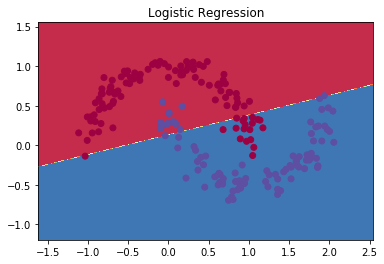

Accuracy: 0.845000


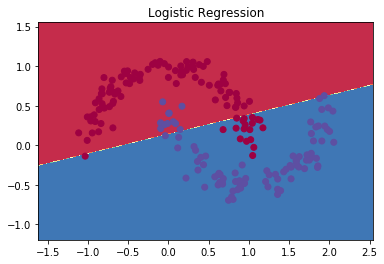

Accuracy: 0.845000

coeffs from sci-kit learn
[0.47289679]
[[ 0.93486703 -3.73569109]]

My coeffs
[[ 0.67086866]
 [ 1.22362188]
 [-4.96526411]]


In [9]:
def generate_data():
    np.random.seed(0)
    X, y = datasets.make_moons(1000, noise=0.10)
    return X, y

def visualize(X, y, clf):
    # plt.scatter(X[:, 0], X[:, 1], s=40, c=y, cmap=plt.cm.Spectral)
    # plt.show()
    plot_decision_boundary( lambda x: clf.predict(x), X, y)

def plot_decision_boundary(pred_func, X, y):
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole gid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral)
    plt.title("Logistic Regression")
    plt.show()
    
def classify(X, y):
    #clf = linear_model.LogisticRegressionCV()
    clf = SGDClassifier(max_iter=1000, penalty='l2')
    clf.fit(X, y)
    return clf

X, y = generate_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
# visualize(X, y)
clf = classify(X_train, y_train)
visualize(X_test, y_test, clf)

print("Accuracy: %f" % accuracy_score(y_test, clf.predict(X_test)))

def add_ones(X) :
    return np.hstack((np.ones((X.shape[0], 1)), X))

#### add ones
X_train = add_ones(X_train)
my_logreg = my_logistic_regression(epochs = 50, batch_size = 40)
my_logreg.fit(X_train, y_train, eta = 0.1, alpha = 0.0001)

pdb = lambda x : my_logreg.predict(x)  

# Set min and max values and give it some padding
x_min, x_max = X_test[:, 0].min() - .5, X_test[:, 0].max() + .5
y_min, y_max = X_test[:, 1].min() - .5, X_test[:, 1].max() + .5
h = 0.01
# Generate a grid of points with distance h between them
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
# Predict the function value for the whole gid
Z = pdb(np.c_[np.ones((xx.shape)).ravel(), xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
# Plot the contour and training examples
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=plt.cm.Spectral)
plt.title("Logistic Regression")
plt.show()

print("Accuracy: %f" % accuracy_score(y_test, my_logreg.predict(add_ones(X_test))))


print("")
print("coeffs from sci-kit learn")
print(clf.intercept_)
print(clf.coef_)
print("")
print("My coeffs")
print(my_logreg.theta)


## Cross validation and bias variance functions

These are taken from project one

In [10]:
def MSE(x, y):
    return np.mean(np.power(x-y, 2))

def r2d2score(ytrue, ypredict):
    truemean = np.mean(ytrue)
    return 1 - (np.sum(np.power(ytrue-ypredict, 2))/np.sum(np.power(ytrue-truemean, 2)))

# variance of a column of row vector x
def variance(x):
    return np.mean(np.power(x - np.mean(x), 2))

# This function does k-fold cross validation 
# It takes a k, a matrix X of inputs and corresponding true values z (all of appropirate sizes)
# It also takes a model which we assume have fit, predict, and coefficients functions.
# Both should work on these matrices 
# We return the expected error, and a list of computed coefficients for our model
def cross_validation(k, X, z, model):
    
    sqdiffs = []
    clength = len(X[:,0]) # the length of the first column in X
    permutation = np.random.permutation(clength) # a permutation of the indexes of rows in X
    partitions = np.array_split(permutation, k) # The permutation is devided in to k almost equally big groups
    
    for i in range(0,k) :
        # create a mask to pick everything but the elements in the i'th partition
        mask = np.ones(clength,dtype=bool)
        mask[partitions[i]] = 0
        # now train on everything but the i'th partition
        model.fit(X[mask], z[mask])
        # make the mask the picks only the elements of the i'th partition
        notmask = np.invert(mask)
        # update the sqdiffs of predicted values and the true values in the i'th partition  
        zpredict = model.predict(X[notmask])
        sqdiffs.append(np.power(zpredict - z[notmask],2))
    
    pred_mse = np.mean(sqdiffs)
    return pred_mse

# This function tries to estimate the variance and bias of our model  
# It takes a k, a matrix X of inputs, and corresponding true values z (all of appropirate sizes)
# It also takes a model which we assume have fit and predict functions.
# We return the variance and bias of computing the model on k subsets of X
# when compared to a single "true" set
def BV_estimate(k, X, z, model):
    
    clength = len(X[:,0]) # the length of the first column in X
    permutation = np.random.permutation(clength) # a permutation of the indexes of rows in X
    partitions = np.array_split(permutation, k+1) # The permutation is devided in to k+1 almost equally big groups
    preds_list = [] # this will be a list of the predicted out comes
    
    # create a mask to pick everything in the k'th partition
    # this is the partition we will compare aginst
    fixed_mask = np.zeros(clength,dtype=bool)
    fixed_mask[partitions[k]] = 1
       
    for i in range(0,k) :
        # create a mask to pick everything but the i'th partition
        mask = np.ones(clength,dtype=bool)
        mask[partitions[i]] = 0
        mask[partitions[k]] = 0
        # now train on the i'th partition
        model.fit(X[mask], z[mask])
        # now predict what will happen on the fixed set
        zpredict = model.predict(X[fixed_mask]).reshape(-1,1)
        preds_list.append(zpredict)
    
    # transform from list of column vectors to a single matrix
    # each row contains the prediction of a single xy point
    preds_matrix = np.hstack(preds_list)
    
    vari = np.mean(np.apply_along_axis(variance, 1, preds_matrix))
    bias = np.mean(np.power(np.mean(preds_matrix - z[fixed_mask].reshape(-1,1), axis=1), 2))
    #mse = np.mean(np.power(preds_matrix - z[fixed_mask, :], 2))
    
    return bias, vari

##usage example:
#pRidge = polynomialOLS(4)
#print("Using 9 folds to predict variance and bias for a polynomial of degree %i." % 2)
#print(BV_estimate(9, XY, z, pRidge))


## 1D Ising model data

We produce the test data for the 1D Ising model.
We also set up the design matrix to be used with linear regression.

In [19]:
# System size and number of systems
L = 40
sysnum = 1000

# random Ising states
states = np.random.choice([-1,1], size=(sysnum, L))

def ising_energies(states,L):
    """
    This function calculates the energies of the states in the nn Ising Hamiltonian
    From the project description 
    """
    J=np.zeros((L,L),)
    for i in range(L):
        J[i,(i+1)%L]-=1.0
    
    # compute energies
    E = np.einsum('...i,ij,...j->...',states,J,states)
    return E

# calculate Ising energies
energies=ising_energies(states,L)

####
# This function will take a list (a state) s
# and return a list consisting of all pairs s[j]s[k] 
def state_vector(state) : 
    l = len(state)
    return [state[j]*state[k] for k in range(l) for j in range(l)]

#s0 = states[0]
#print(s0)
#print(state_vector(s0))

####
# This function takes a list of states
# transforms each state to a list of interaction products
# this stacks those lists vertically to create the state vector
def state_matrix(states) : 
    return np.vstack([state_vector(s) for s in states])

#print(state_matrix(states).shape)

SM = state_matrix(states)
states_train, states_test, E_train, E_test = train_test_split(SM, energies, test_size=0.2)



### Statistics test for OLS on 1d ising data

In [20]:
linreg = LinearRegression()

print("")
print("Using 9 folds to predict variance and bias")
b, v = BV_estimate(9, states_train, E_train, linreg)
print("The bias is %f" % b)
print("The variance is %f" % v)
print("")
linreg.fit(states_train, E_train)
print("We train on all training data, and compare to unseen data.")
print("MSE : %f " % MSE(E_test, linreg.predict(states_test)))
print("R2 score: %f" % r2_score(E_test, linreg.predict(states_test)))




Using 9 folds to predict variance and bias
The bias is 4.148684
The variance is 2.669402

We train on all training data, and compare to unseen data.
MSE : 0.000000 
R2 score: 1.000000


### Statistics test for Ridge and Lasso on 1d ising data

In [21]:
# We first do the ridge method

print("Testing Ridge method")
print("")
print("First we use 10 fold cross validation to decide which model is best.")
print("")

#Since printing out all the results of cross validation with different lambdas get tedious to read
# we make a list of cv values and corresponding degrees and lambdas. 
# Then we can just sort by the cv value to pick the best model
cv_list = []

for a in [0.1, 0.01, 0.001, 0.0001, 0.00001] : 
    ridge = Ridge(alpha = a)
    cv = cross_validation(10, states_train, E_train, ridge)
    cv_list.append((a,cv))

cv_list.sort(key=lambda tup: tup[1]) #sort the list by the cv value

best_tup = cv_list[0]

print("The best model had a lambda of %f " % best_tup[0])
print("It had a predicted error of %f" % best_tup[1])
print("")
ridge = Ridge(alpha = best_tup[0])
print("Using 9 folds to predict variance and bias")
b, v = BV_estimate(9, states_train, E_train, ridge)
print("The bias is %f" % b)
print("The variance is %f" % v)
print("")
print("We train it on all the test data, and test it against the unseen data.")
ridge.fit(states_train, E_train)
prediction = ridge.predict(states_test)
print("MSE: %f" % MSE(prediction, E_test))
print("R2 score : %f" % r2_score(E_test, prediction))

# Then we do the Lasso method

print("")
print("")
print("")

print("Testing Lasso method")
print("")
print("First we use 10 fold cross validation to decide which model is best.")
print("")

#Since printing out all the results of cross validation with different lambdas get tedious to read
# we make a list of cv values and corresponding degrees and lambdas. 
# Then we can just sort by the cv value to pick the best model
cv_list = []

for a in [0.1, 0.01, 0.001, 0.0001, 0.00001] : 
    ridge = Lasso(alpha = a)
    cv = cross_validation(10, states_train, E_train, ridge)
    cv_list.append((a,cv))

cv_list.sort(key=lambda tup: tup[1]) #sort the list by the cv value

best_tup = cv_list[0]

print("The best model had a lambda of %f " % best_tup[0])
print("It had a predicted error of %f" % best_tup[1])
print("")
lasso = Lasso(alpha = best_tup[0])
print("Using 9 folds to predict variance and bias")
b, v = BV_estimate(9, states_train, E_train, lasso)
print("The bias is %f" % b)
print("The variance is %f" % v)
print("")
print("We train it on all the test data, and test it against the unseen data.")
lasso.fit(states_train, E_train)
prediction = lasso.predict(states_test)
print("MSE: %f" % MSE(prediction, E_test))
print("R2 score : %f" % r2_score(E_test, prediction))



Testing Ridge method

First we use 10 fold cross validation to decide which model is best.

The best model had a lambda of 0.000100 
It had a predicted error of 3.054279

Using 9 folds to predict variance and bias
The bias is 4.812670
The variance is 2.391355

We train it on all the test data, and test it against the unseen data.
MSE: 0.000000
R2 score : 1.000000



Testing Lasso method

First we use 10 fold cross validation to decide which model is best.



C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


The best model had a lambda of 0.001000 
It had a predicted error of 0.000048

Using 9 folds to predict variance and bias
The bias is 0.000043
The variance is 0.000000

We train it on all the test data, and test it against the unseen data.
MSE: 0.000048
R2 score : 0.999999


### What the coefficient matrices look like

For each method we now print a heat map of the coefficients


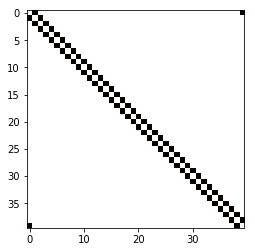

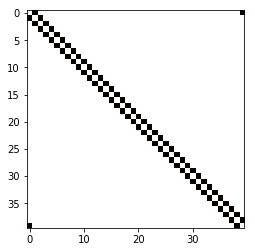

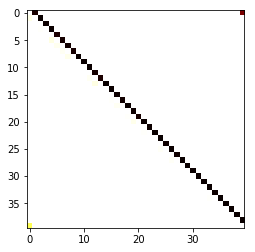

In [22]:
print("For each method we now print a heat map of the coefficients")

linreg = LinearRegression()
linreg.fit(states_train, E_train)
plt.imshow(linreg.coef_.reshape(L,L), cmap='hot')
plt.show()

ridgereg = Ridge(alpha = 0.001)
ridgereg.fit(states_train, E_train)
plt.imshow(ridgereg.coef_.reshape(L,L), cmap='hot')
plt.show()

lassoreg = Lasso(alpha = 0.001)
lassoreg.fit(states_train, E_train)
plt.imshow(lassoreg.coef_.reshape(L,L), cmap='hot')
plt.show()

### The following code produces nice looking heat maps


In [15]:
############## This is code to do neat plotting, taken from:
# https://matplotlib.org/gallery/images_contours_and_fields/image_annotated_heatmap.html#sphx-glr-gallery-images-contours-and-fields-image-annotated-heatmap-py
############################################################################
############################################################################
############################################################################
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Arguments:
        data       : A 2D numpy array of shape (N,M)
        row_labels : A list or array of length N with the labels
                     for the rows
        col_labels : A list or array of length M with the labels
                     for the columns
    Optional arguments:
        ax         : A matplotlib.axes.Axes instance to which the heatmap
                     is plotted. If not provided, use current axes or
                     create a new one.
        cbar_kw    : A dictionary with arguments to
                     :meth:`matplotlib.Figure.colorbar`.
        cbarlabel  : The label for the colorbar
    All other arguments are directly passed on to the imshow call.
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    for edge, spine in ax.spines.items():
        spine.set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=["black", "white"],
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Arguments:
        im         : The AxesImage to be labeled.
    Optional arguments:
        data       : Data used to annotate. If None, the image's data is used.
        valfmt     : The format of the annotations inside the heatmap.
                     This should either use the string format method, e.g.
                     "$ {x:.2f}", or be a :class:`matplotlib.ticker.Formatter`.
        textcolors : A list or array of two color specifications. The first is
                     used for values below a threshold, the second for those
                     above.
        threshold  : Value in data units according to which the colors from
                     textcolors are applied. If None (the default) uses the
                     middle of the colormap as separation.

    Further arguments are passed on to the created text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[im.norm(data[i, j]) > threshold])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

############################################################################
############################################################################
############################################################################
##### plotting code over


## Using Neural net for 1D Ising Data

With 10 hidden neurons and a learning rate of 0.100000, we get and error of 60.971162
With 10 hidden neurons and a learning rate of 0.010000, we get and error of 75.269095
With 10 hidden neurons and a learning rate of 0.001000, we get and error of 50.071226
With 10 hidden neurons and a learning rate of 0.000100, we get and error of 41.678367
With 20 hidden neurons and a learning rate of 0.100000, we get and error of 66.120911
With 20 hidden neurons and a learning rate of 0.010000, we get and error of 83.195690
With 20 hidden neurons and a learning rate of 0.001000, we get and error of 52.872054
With 20 hidden neurons and a learning rate of 0.000100, we get and error of 42.456746
With 40 hidden neurons and a learning rate of 0.100000, we get and error of 51.909411
With 40 hidden neurons and a learning rate of 0.010000, we get and error of 74.213214
With 40 hidden neurons and a learning rate of 0.001000, we get and error of 48.359083
With 40 hidden neurons and a learning rate of 0.000100

C:\Users\Admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:111: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


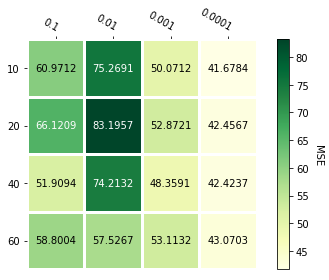

In [31]:
########## 
# first we set up the Ising energy data again, 
# we need to do it again, since for the neural net
# we don't want to build the states matrix

# System size and number of systems
L = 40
sysnum = 1000

# random Ising states
states = np.random.choice([-1.0,1.0], size=(sysnum, L))

def ising_energies(states,L):
    """
    This function calculates the energies of the states in the nn Ising Hamiltonian
    From the project description 
    """
    J=np.zeros((L,L),)
    for i in range(L):
        J[i,(i+1)%L]-=1.0
    
    # compute energies
    E = np.einsum('...i,ij,...j->...',states,J,states)
    return E

# calculate Ising energies
energies=ising_energies(states,L)

states_train, states_test, E_train, E_test = train_test_split(states, energies, test_size=0.2)


#######
# now we try with different network configurations

learning_rates = [0.1, 0.01, 0.001, 0.0001]
hidden_neurons = [10, 20, 40, 60]
mses = np.zeros((4,4))

for i in range(0,4) :
    for j in range(0,4) :
        # create a new net and train with the given number of neurons and learning_rate
        net = my_NN([40,hidden_neurons[i], 1], 'sigmoid', 'linear') 
        net.train(states_train, E_train, cost_function = 'square error', learning_rate = learning_rates[j], epochs = 100, batch_size = 400)
        prediction = net.predict(states_test)
        error = mean_squared_error(prediction, E_test)
        mses[i][j] = error
        print("With %d hidden neurons and a learning rate of %f, we get and error of %f" % (hidden_neurons[i], learning_rates[j], error))

# now plot the mses in a heat map
fig, ax = plt.subplots()
im, cbar = heatmap(mses, hidden_neurons, learning_rates, ax=ax, cmap="YlGn", cbarlabel="MSE")
texts = annotate_heatmap(im, valfmt="{x:.4f}")
fig.tight_layout()
plt.show()


### Working with best 1d ising net

In [29]:
net = my_NN([40,40, 1], 'sigmoid', 'linear') 
net.train(states_train, E_train, cost_function = 'square error', learning_rate = 0.0001, epochs = 500, batch_size = 400)
prediction = net.predict(states_test)
print("Training the net with 40 hidden neurons and a learning rate of 0.0001 for 500 epochs")
print("MES: %f" % mean_squared_error(prediction, E_test))



Training the net with 40 hidden neurons and a learning rate of 0.0001 for 500 epochs
MES: 44.621208


# Classification of ising states

We now turn to the ising data and see how our network preforms on it

In [9]:
##### prepare training and test data sets
import pickle, os

# path to data directory
#path_to_data=os.path.expanduser('~')+'\Documents\GitHub\ml-exercises\Rapport 2\Isingdata\\'

# load data
file_name = "Ising2DFM_reSample_L40_T=All.pkl" # this file contains 16*10000 samples taken in T=np.arange(0.25,4.0001,0.25)
data = pickle.load(open(file_name,'rb')) # pickle reads the file and returns the Python object (1D array, compressed bits)
data = np.unpackbits(data).reshape(-1, 1600) # Decompress array and reshape for convenience
data=data.astype('int')
data[np.where(data==0)]=-1 # map 0 state to -1 (Ising variable can take values +/-1)

file_name = "Ising2DFM_reSample_L40_T=All_labels.pkl" # this file contains 16*10000 samples taken in T=np.arange(0.25,4.0001,0.25)
labels = pickle.load(open(file_name,'rb')) # pickle reads the file and returns the Python object (here just a 1D array with the binary labels)

# divide data into ordered, critical and disordered
X_ordered=data[:70000,:]
Y_ordered=labels[:70000]
# we will ignore the critical temperatures
#X_critical=data[70000:100000,:]
#Y_critical=labels[70000:100000]

X_disordered=data[100000:,:]
Y_disordered=labels[100000:]

del data,labels

# define training and test data sets
X=np.concatenate((X_ordered,X_disordered))
Y=np.concatenate((Y_ordered,Y_disordered))

# pick random data points from ordered and disordered states 
# to create the training and test sets
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.2)

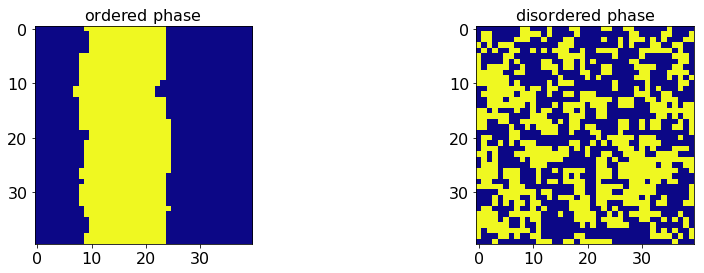

In [10]:
##### plot a few Ising states

# set colourbar map
cmap_args=dict(cmap='plasma_r')

# plot states
fig, axarr = plt.subplots(nrows=1, ncols=2)

axarr[0].imshow(X_ordered[40001].reshape(40,40),**cmap_args)
axarr[0].set_title('$\\mathrm{ordered\\ phase}$',fontsize=16)
axarr[0].tick_params(labelsize=16)

im=axarr[1].imshow(X_disordered[50001].reshape(40,40),**cmap_args)
axarr[1].set_title('$\\mathrm{disordered\\ phase}$',fontsize=16)
axarr[1].tick_params(labelsize=16)

fig.subplots_adjust(right=2.0)

plt.show()


## Classifying using Logistic regression

With a regularization of 0.100000 and a learning rate of 0.100000, we get an accuracy of 0.459538
With a regularization of 0.100000 and a learning rate of 0.010000, we get an accuracy of 0.417038
With a regularization of 0.100000 and a learning rate of 0.001000, we get an accuracy of 0.672500
With a regularization of 0.100000 and a learning rate of 0.000100, we get an accuracy of 0.639500
With a regularization of 0.010000 and a learning rate of 0.100000, we get an accuracy of 0.453115
With a regularization of 0.010000 and a learning rate of 0.010000, we get an accuracy of 0.422192
With a regularization of 0.010000 and a learning rate of 0.001000, we get an accuracy of 0.653308
With a regularization of 0.010000 and a learning rate of 0.000100, we get an accuracy of 0.661538
With a regularization of 0.001000 and a learning rate of 0.100000, we get an accuracy of 0.455192
With a regularization of 0.001000 and a learning rate of 0.010000, we get an accuracy of 0.502692
With a regularizatio

C:\Users\Admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:111: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


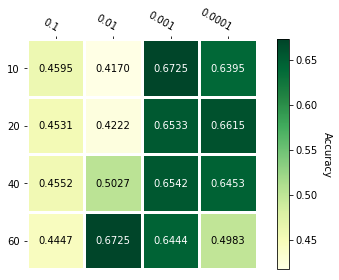

In [45]:
######
# now we try with configurations

learning_rates = [0.1, 0.01, 0.001, 0.0001]
regularization = [0.1, 0.01, 0.001, 0.0001]
mses = np.zeros((4,4))

for i in range(0,4) :
    for j in range(0,4) :
        my_logreg = my_logistic_regression(epochs = 10, batch_size = 800)
        my_logreg.fit(add_ones(X_train),Y_train, eta = learning_rates[j], alpha = regularization[i] )
        prediction = my_logreg.predict(add_ones(X_test))
        error = accuracy_score(Y_test, np.around(my_logreg.predict(add_ones(X_test))))
        mses[i][j] = error
        print("With a regularization of %f and a learning rate of %f, we get an accuracy of %f" % (regularization[i], learning_rates[j], error))

# now plot the mses in a heat map
fig, ax = plt.subplots()
im, cbar = heatmap(mses, regularization, learning_rates, ax=ax, cmap="YlGn", cbarlabel="Accuracy")
texts = annotate_heatmap(im, valfmt="{x:.4f}")
fig.tight_layout()
plt.show()



### working with best logistic  2d model 

In [48]:
my_logreg = my_logistic_regression(epochs = 50, batch_size = 800)
my_logreg.fit(add_ones(X_train),Y_train, eta = 0.001, alpha = 0.1 )
prediction = my_logreg.predict(add_ones(X_test))
error = accuracy_score(Y_test, np.around(my_logreg.predict(add_ones(X_test))))
print("Accuracy: %f" % error)


Accuracy: 0.640115


## Classifying using neural net

With 10 hidden neurons and a learning rate of 0.100000, we get an accuracy of 0.539077
With 10 hidden neurons and a learning rate of 0.010000, we get an accuracy of 0.606885
With 10 hidden neurons and a learning rate of 0.001000, we get an accuracy of 0.668115
With 10 hidden neurons and a learning rate of 0.000100, we get an accuracy of 0.650269
With 20 hidden neurons and a learning rate of 0.100000, we get an accuracy of 0.717577
With 20 hidden neurons and a learning rate of 0.010000, we get an accuracy of 0.672808
With 20 hidden neurons and a learning rate of 0.001000, we get an accuracy of 0.696154
With 20 hidden neurons and a learning rate of 0.000100, we get an accuracy of 0.472577
With 40 hidden neurons and a learning rate of 0.100000, we get an accuracy of 0.865846
With 40 hidden neurons and a learning rate of 0.010000, we get an accuracy of 0.682462
With 40 hidden neurons and a learning rate of 0.001000, we get an accuracy of 0.683192
With 40 hidden neurons and a learning rate 

C:\Users\Admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:111: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


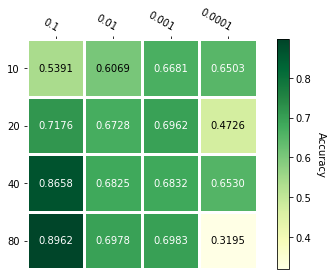

In [52]:
#######
# now we try with different network configurations

learning_rates = [0.1, 0.01, 0.001, 0.0001]
hidden_neurons = [10, 20, 40, 80]
mses = np.zeros((4,4))

for i in range(0,4) :
    for j in range(0,4) :
        # create a new net and train with the given number of neurons and learning_rate
        net = my_NN([1600,hidden_neurons[i], 1], 'sigmoid', 'sigmoid') 
        net.train(X_train, Y_train, cost_function = 'cross entropy', learning_rate = learning_rates[j], epochs = 10, batch_size = 400)
        prediction = np.around(net.predict(X_test))
        error = accuracy_score(prediction, Y_test)
        mses[i][j] = error
        print("With %d hidden neurons and a learning rate of %f, we get an accuracy of %f" % (hidden_neurons[i], learning_rates[j], error))

# now plot the mses in a heat map
fig, ax = plt.subplots()
im, cbar = heatmap(mses, hidden_neurons, learning_rates, ax=ax, cmap="YlGn", cbarlabel="Accuracy")
texts = annotate_heatmap(im, valfmt="{x:.4f}")
fig.tight_layout()
plt.show()

### Working with best model

In [54]:
net = my_NN([1600, 80, 1], 'sigmoid', 'sigmoid') 
net.train(X_train, Y_train, cost_function = 'cross entropy', learning_rate = 0.1, epochs = 50, batch_size = 400, verbose = True)
prediction = np.around(net.predict(X_test))
error = accuracy_score(prediction, Y_test)
print("")
print("With %d hidden neurons and a learning rate of %f, we get an accuracy of %f" % (80, 0.1, error))


Working on epoch 4
Before this epoch the loss is 0.410600
Working on epoch 9
Before this epoch the loss is 0.203589
Working on epoch 14
Before this epoch the loss is 0.130168
Working on epoch 19
Before this epoch the loss is 0.091742
Working on epoch 24
Before this epoch the loss is 0.067972
Working on epoch 29
Before this epoch the loss is 0.055433
Working on epoch 34
Before this epoch the loss is 0.042094
Working on epoch 39
Before this epoch the loss is 0.034476
Working on epoch 44
Before this epoch the loss is 0.028992
Working on epoch 49
Before this epoch the loss is 0.024581

With 80 hidden neurons and a learning rate of 0.000100, we get an accuracy of 0.975846


In [55]:
print("With %d hidden neurons and a learning rate of %f, we get an accuracy of %f" % (80, 0.1, error))

With 80 hidden neurons and a learning rate of 0.100000, we get an accuracy of 0.975846
